In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Ejercicio de clasificación

Tenemos el dataset de incumplimiento de clientes para una compañía de tarjetas de crédito. De cada cliente se tiene el balance que le llegó de la tarjeta, si es un estudiante universitario o no y el sueldo anual. Además contamos si el cliente incumplió el pago o no. 

In [2]:
# Usamos la liberia ISLP que tiene varios dataset de ejemplos (https://pypi.org/project/ISLP/)
from ISLP import load_data

default_df = load_data("Default")

Como siempre, vemos un poco nuestros datos

In [3]:
default_df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [4]:
default_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [5]:
default_df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


Convirtamos a las columnas **default** y **student** en columnas numericas

In [6]:
default_df["Incumplimiento"] = default_df["default"].apply(lambda x: "Si" if x == "Yes" else "No")
default_df["Estudiante"] = default_df["student"].apply(lambda x: "Si" if x == "Yes" else "No")

default_df["default"] = default_df["default"].apply(lambda x: 1 if x == "Yes" else 0)
default_df["student"] = default_df["student"].apply(lambda x: 1 if x == "Yes" else 0)

In [7]:
default_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   default         10000 non-null  int64  
 1   student         10000 non-null  int64  
 2   balance         10000 non-null  float64
 3   income          10000 non-null  float64
 4   Incumplimiento  10000 non-null  object 
 5   Estudiante      10000 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 468.9+ KB


Veamos la clases (default):

In [8]:
default_df.default.value_counts()

0    9667
1     333
Name: default, dtype: int64

Observese que tenemos una gran desproporsión de clases. Tenemos 3.3% de observaciónes de personas que no pagaron. 

Obtengamos algunas visualizaciones de los datos

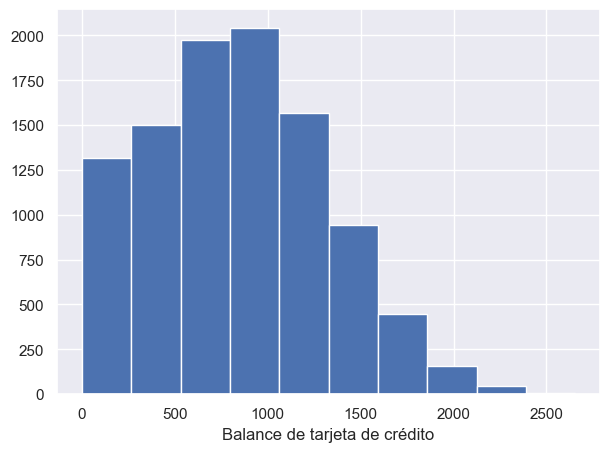

In [9]:
plt.figure(figsize=(7, 5))
default_df["balance"].hist()
plt.xlabel("Balance de tarjeta de crédito")
plt.show()

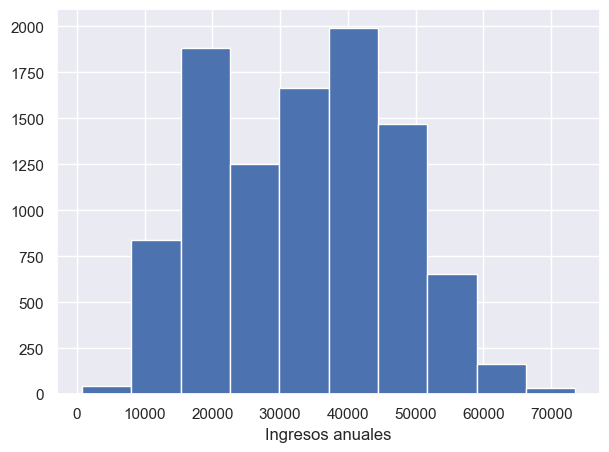

In [10]:
plt.figure(figsize=(7, 5))
default_df["income"].hist()
plt.xlabel("Ingresos anuales")
plt.show()

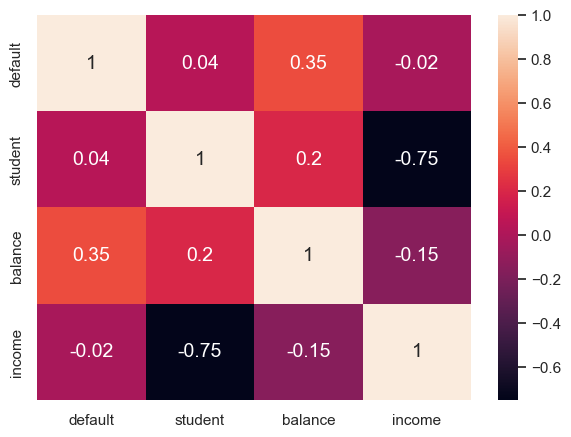

In [11]:
# Veamos la correlacion cruzada
plt.figure(figsize=(7, 5))
default_profit = default_df.corr(numeric_only=True).round(2)
sns.heatmap(data=default_profit, annot=True, annot_kws={"size": 14});

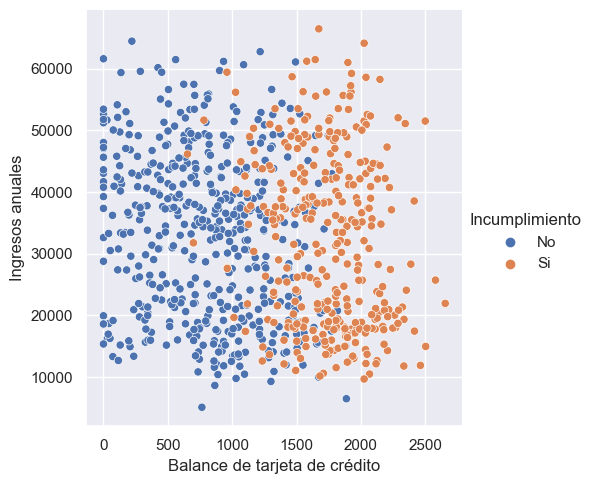

In [12]:
#Hacemos esto para poder graficar y poder visualizar mejor
df_sample_no_default = default_df[default_df["default"] == 0].copy()
df_sample_no_default = df_sample_no_default.sample(frac=0.05)
df_sample_default = default_df[default_df["default"] == 1].copy()

g = sns.relplot(data=pd.concat([df_sample_no_default, df_sample_default]), x="balance", y="income", hue="Incumplimiento", 
                kind="scatter", legend=True)
plt.xlabel("Balance de tarjeta de crédito")
plt.ylabel("Ingresos anuales");

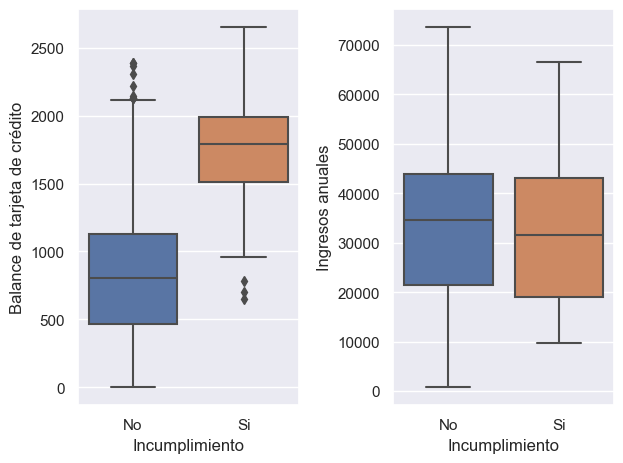

In [13]:
f, ax = plt.subplots(1,2)
sns.boxplot(data=default_df, y="balance", x="Incumplimiento", ax=ax[0])
sns.boxplot(data=default_df, y="income", x="Incumplimiento", ax=ax[1])
ax[0].set_ylabel("Balance de tarjeta de crédito")
ax[1].set_ylabel("Ingresos anuales")
plt.tight_layout();

Veamos un poco la variable de si la persona es estudiante.

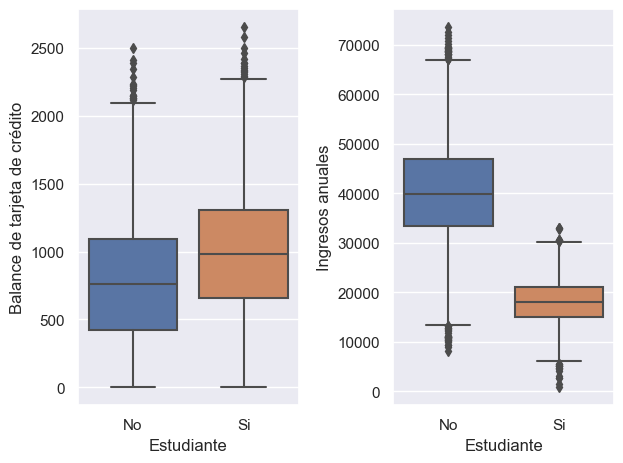

In [14]:
f, ax = plt.subplots(1,2)
sns.boxplot(data=default_df, y="balance", x="Estudiante", ax=ax[0])
sns.boxplot(data=default_df, y="income", x="Estudiante", ax=ax[1])
ax[0].set_ylabel("Balance de tarjeta de crédito")
ax[1].set_ylabel("Ingresos anuales")
plt.tight_layout();

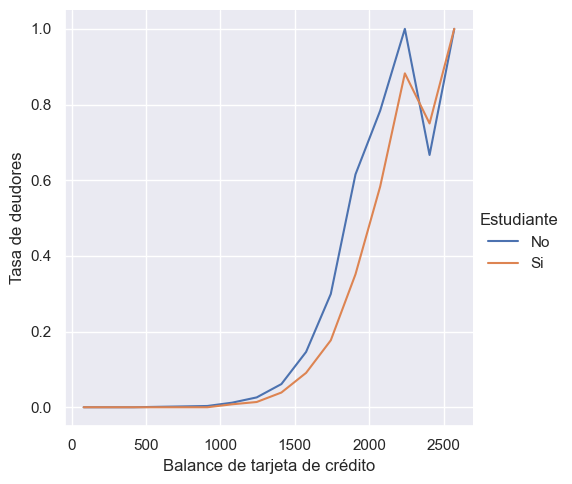

In [15]:
#Obtengamos la tasa de deudores versus si son estudiantes o no
default_df["balance_bin"] = pd.cut(default_df['balance'],16).apply(lambda x: x.mid)

df_grouped = default_df.groupby(["balance_bin", "student"], as_index=False, observed=True).agg({
    "default": ["sum", "count"] 
})
df_grouped.columns = ["balance", "Estudiante", "sum", "count"]
df_grouped["default_rate"] = df_grouped["sum"] / df_grouped["count"]

df_grouped["Estudiante"] = df_grouped["Estudiante"].apply(lambda x: "Si" if x == 1 else "No")

g = sns.relplot(data=df_grouped, x="balance", y="default_rate", hue="Estudiante", 
                kind="line", legend=True)
plt.xlabel("Balance de tarjeta de crédito")
plt.ylabel("Tasa de deudores");

Vemos que los estudiantes, dado un balance, tienden más a pagar la tarjeta de crédito que los no estudiantes.

---
### Primer modelo de regresión logistica

Podemos ver que la variable balance de tarjeta es la mejor candidata para clasificar si la persona va a pagar o no. Por lo que armemos un modelo de regresión logistica simple usando balance.

In [16]:
# como siempre vamos separando nuestras variables predictoras de la variable a predecir
X = default_df.loc[:, ["balance"]].values
y = default_df.loc[:, "default"].values

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

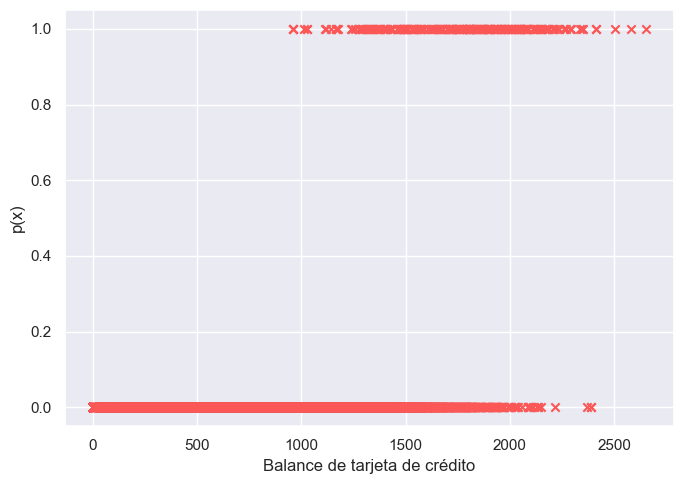

In [18]:
plt.figure(figsize=(7, 5))
plt.scatter(X_train, y_train, marker="x", color="#fb5757")
plt.xlabel("Balance de tarjeta de crédito")
plt.ylabel("p(x)")
plt.tight_layout()
plt.show()

Ya con los datos de entrenamiento, vamos a entrenar el modelo de regresión logistica de [sckit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
# Entrenamos el modelo por máxima verosimilitud
classifier_balance = LogisticRegression(random_state = 0)
classifier_balance.fit(X_train, y_train)

LogisticRegression(random_state=0)

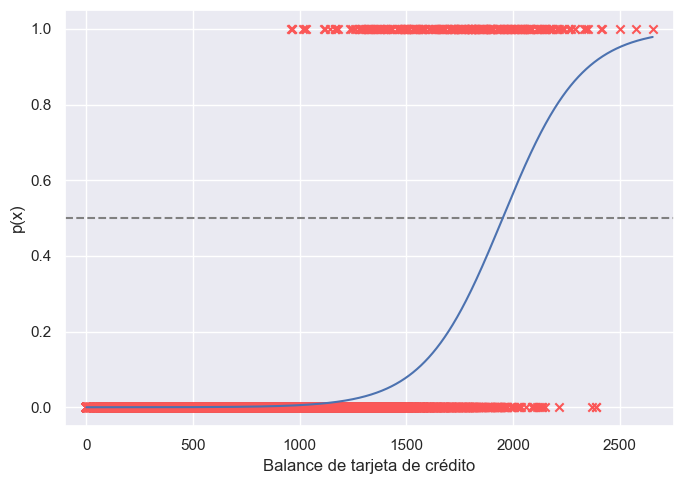

In [21]:
#Obtengamos la funcion logistica
xx = np.linspace(np.min(X_train), np.max(X_train), 1000)
# Usando el metodo que nos da las probabilidades
yy = classifier_balance.predict_proba(xx.reshape([-1, 1]))

plt.figure(figsize=(7, 5))
plt.plot([-1000, 100000], [0.5, 0.5], linestyle="--", color="gray")
plt.scatter(X_train, y_train, marker="x", color="#fb5757")
plt.plot(xx, yy[:, 1])
plt.xlabel("Balance de tarjeta de crédito")
plt.ylabel("p(x)")
plt.xlim([np.min(X_train)-100, np.max(X_train)+100])
plt.tight_layout()
plt.show()

----

Vimos que estudiante se veia buen candidato para predecir si la persona iba a pagar o no

In [22]:
X = default_df.loc[:, ["student"]].values
y = default_df.loc[:, "default"].values
X_train_student, X_test_student, y_train_student, y_test_student = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Entrenamos el modelo por máxima verosimilitud
classifier_student = LogisticRegression(random_state = 0)
classifier_student.fit(X_train_student, y_train_student)

LogisticRegression(random_state=0)

Dado que estudiante es una variable booleana, podemos ver que probabilidad predice el modelo:

In [23]:
classifier_student.predict_proba([[1], [0]])[:, -1]

array([0.04342726, 0.02669474])

Vemos que si la persona es estudiante, el modelo le da más probabildad de que no pague... pero habiamos visto que era al revez. **Qué está pasando?**

Aunque un estudiante individual con un saldo de tarjeta de crédito determinado tenderá a tener una menor probabilidad de incumplimiento que un no estudiante con el mismo saldo de tarjeta de crédito, el hecho de que los estudiantes en general tiendan a tener saldos de tarjeta de crédito más altos significa que en general, los estudiantes tienden a incumplir sus obligaciones a un ritmo mayor que los no estudiantes. 

Esta es una distinción importante para una compañía de tarjetas de crédito que está tratando de determinar a quién debe ofrecer crédito. Un estudiante es mas riesgoso sin no tenemos datos de balances. Sin embargo, es menos riesgoso que un no estudiante ante un mismo nivel de balance. 

Este sencillo ejemplo ilustra los peligros con la realización de regresiones que involucran un solo predictor cuando otros predictores también pueden ser relevantes.

Este fenomeno es el que llamamos [factor de confusión](https://es.wikipedia.org/wiki/Factor_de_confusi%C3%B3n).

---
### Modelo de regresión logistica multiple

Intentemos ahora ver ahora un modelo de regresión logistica con todas las entradas del dataset.

Pero antes de entrenar el modelo, veamos que balance esta entre 0 y 2600, e income entre 700 y 73000, es decir income tiene una variabilidad mucho mayor. Lo que queremos hacer es normalizar los features, para que evitemos que por cuestiones simplemente de unidades, una feature tenga mas relevancia que otra. 

In [24]:
default_df.describe()

,default,student,balance,income
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.033300,0.294400,835.374886,33516.981876
std,0.179428,0.455795,483.714985,13336.639563
min,0.000000,0.000000,0.000000,771.967729
25%,0.000000,0.000000,481.731105,21340.462903
50%,0.000000,0.000000,823.636973,34552.644802
75%,0.000000,1.000000,1166.308386,43807.729272
max,1.000000,1.000000,2654.322576,73554.233495


In [25]:
X = default_df.loc[:, ["balance", "income", "student"]].values
y = default_df.loc[:, "default"].values
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y, test_size = 0.25, random_state = 0)

Entonces es el momento de introducir el concepto de escalado o [normalizacion de variables](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [26]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

X_train_total = sc_X.fit_transform(X_train_total) # usamos fit para crear el escalado y aplicar conjunto de entrenamiento
X_test_total = sc_X.transform(X_test_total) # solo hacemos el transform ya que fue escalado anteriormente

In [27]:
# Entrenamos el modelo por máxima verosimilitud
classifier_total = LogisticRegression(random_state = 0)
classifier_total.fit(X_train_total, y_train_total)

LogisticRegression(random_state=0)

## Metricas de evaluación

Empecemos por la métrica más básica, el [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score):

In [28]:
# Empecemos por la metrica mas basica, el accuracy:
print(f"Porcentaje de muestras bien clasificadas: {(classifier_balance.score(X_test, y_test)*100)}%")
print(f"Porcentaje de muestras bien clasificadas usando todos los atributos: {(classifier_total.score(X_test_total, y_test_total)*100)}%")

Porcentaje de muestras bien clasificadas: 97.0%
Porcentaje de muestras bien clasificadas usando todos los atributos: 97.08%


A simple vista los dos modelos son excelentes, pero usemos un modelo de baseline que siempre diga que todos los clientes pagarán la tarjeta:

In [29]:
from sklearn.metrics import accuracy_score
prediccion_naive = np.zeros_like(y_test) 

print(f"Porcentaje de muestras bien clasificadas por el modelo naive: {accuracy_score(y_test, prediccion_naive)*100}%")

Porcentaje de muestras bien clasificadas por el modelo naive: 96.16%


Que paso? Por que el modelo naive es tan bueno? 

Sencillo, recordemos que en el dataset habia aprox. 9600 datos con el target igual a cero, o sea que pagaron, y 300 con el target igual a 1, es decir que no pagaron. 

Es decir, tenemos un gran desbalance de clases, en donde la positiva es mucho mas chica que la negativa. Usemos otras metricas si podemos ver como es el resultado.

Empecemos por la [matriz de confusión](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#confusion-matrix):

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_test = classifier_balance.predict(X_test)
y_pred_total_test = classifier_total.predict(X_test_total)

In [31]:
cm_balanced = confusion_matrix(y_test, y_pred_test)
cm_total = confusion_matrix(y_test_total, y_pred_total_test)
cm_naive = confusion_matrix(y_test, prediccion_naive)

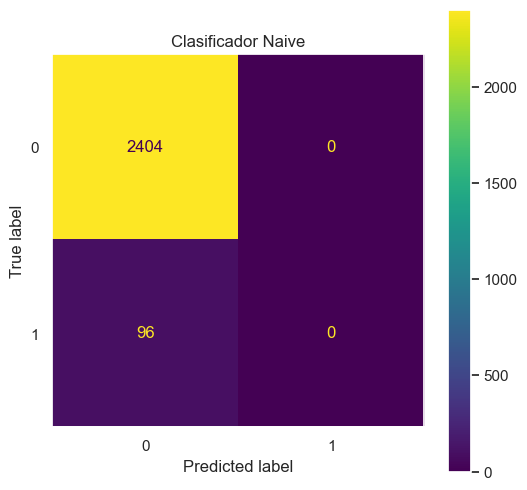

In [32]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_naive,
                              display_labels=classifier_balance.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Clasificador Naive");

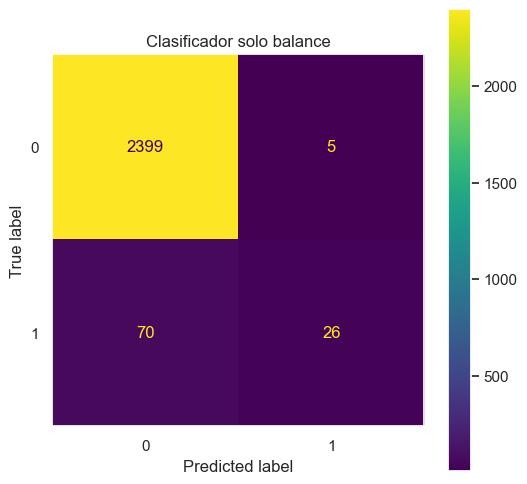

In [33]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_balanced,
                              display_labels=classifier_balance.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Clasificador solo balance");

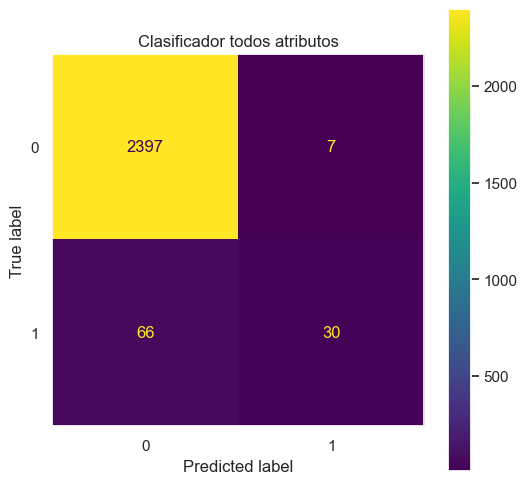

In [34]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_total,
                              display_labels=classifier_total.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Clasificador todos atributos");

In [35]:
# Midamos la sensibilidad y especificidad
print("Modelo Naive")
P = np.sum(cm_naive[1, :])
N = np.sum(cm_naive[0, :])
TP = cm_naive[1, 1]
TN = cm_naive[0, 0]
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")

print("\n")
print("Modelo 1 solo atributo")
P = np.sum(cm_balanced[1, :])
N = np.sum(cm_balanced[0, :])
TP = cm_balanced[1, 1]
TN = cm_balanced[0, 0]
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")

print("\n")
print("Modelo todos los atributos")
P = np.sum(cm_total[1, :])
N = np.sum(cm_total[0, :])
TP = cm_total[1, 1]
TN = cm_total[0, 0]
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")


Modelo Naive
Sensibilidad: 0.0
Especificidad: 1.0


Modelo 1 solo atributo
Sensibilidad: 0.2708333333333333
Especificidad: 0.9979201331114809


Modelo todos los atributos
Sensibilidad: 0.3125
Especificidad: 0.9970881863560732


Midamos la exactitud balanceada

In [36]:
print("Modelo Naive")
P = np.sum(cm_naive[1, :])
N = np.sum(cm_naive[0, :])
TP = cm_naive[1, 1]
TN = cm_naive[0, 0]
TPR = TP/P
TNR = TN/N
print(f"Exactitud balanceada: {(TPR + TNR)/2}")

print("\n")
print("Modelo 1 solo atributo")
P = np.sum(cm_balanced[1, :])
N = np.sum(cm_balanced[0, :])
TP = cm_balanced[1, 1]
TN = cm_balanced[0, 0]
TPR = TP/P
TNR = TN/N
print(f"Exactitud balanceada: {(TPR + TNR)/2}")

print("\n")
print("Modelo todos los atributos")
P = np.sum(cm_total[1, :])
N = np.sum(cm_total[0, :])
TP = cm_total[1, 1]
TN = cm_total[0, 0]
TPR = TP/P
TNR = TN/N
print(f"Exactitud balanceada: {(TPR + TNR)/2}")

Modelo Naive
Exactitud balanceada: 0.5


Modelo 1 solo atributo
Exactitud balanceada: 0.6343767332224071


Modelo todos los atributos
Exactitud balanceada: 0.6547940931780366


Midamos ahora la precisión y especificidad

In [37]:
from sklearn.metrics import precision_score, recall_score

print("Modelo Naive")
print(f"Precision: {precision_score(y_test, prediccion_naive, zero_division=0)}")
print(f"Especificidad: {recall_score(y_test, prediccion_naive, zero_division=0)}")

print("\n")
print("Modelo 1 solo atributo")
print(f"Precision: {precision_score(y_test, y_pred_test, zero_division=0)}")
print(f"Especificidad: {recall_score(y_test, y_pred_test, zero_division=0)}")

print("\n")
print("Modelo todos los atributos")
print(f"Precision: {precision_score(y_test_total, y_pred_total_test, zero_division=0)}")
print(f"Especificidad: {recall_score(y_test_total, y_pred_total_test, zero_division=0)}")

Modelo Naive
Precision: 0.0
Especificidad: 0.0


Modelo 1 solo atributo
Precision: 0.8387096774193549
Especificidad: 0.2708333333333333


Modelo todos los atributos
Precision: 0.8108108108108109
Especificidad: 0.3125


In [38]:
from sklearn.metrics import f1_score, fbeta_score

print("Modelo Naive")
print(f"F1-score: {f1_score(y_test, prediccion_naive, zero_division=0)}")
print(f"F2-score: {fbeta_score(y_test, prediccion_naive, zero_division=0, beta=2)}")
print(f"F0.5-score: {fbeta_score(y_test, prediccion_naive, zero_division=0, beta=0.5)}")

print("\n")
print("Modelo 1 solo atributo")
print(f"F1-score: {f1_score(y_test, y_pred_test, zero_division=0)}")
print(f"F2-score: {fbeta_score(y_test, y_pred_test, zero_division=0, beta=2)}")
print(f"F0.5-score: {fbeta_score(y_test, y_pred_test, zero_division=0, beta=0.5)}")

print("\n")
print("Modelo todos los atributos")
print(f"F1-score: {f1_score(y_test_total, y_pred_total_test, zero_division=0)}")
print(f"F2-score: {fbeta_score(y_test_total, y_pred_total_test, zero_division=0, beta=2)}")
print(f"F0.5-score: {fbeta_score(y_test_total, y_pred_total_test, zero_division=0, beta=0.5)}")

Modelo Naive
F1-score: 0.0
F2-score: 0.0
F0.5-score: 0.0


Modelo 1 solo atributo
F1-score: 0.40944881889763773
F2-score: 0.31325301204819267
F0.5-score: 0.5909090909090908


Modelo todos los atributos
F1-score: 0.45112781954887216
F2-score: 0.35629453681710216
F0.5-score: 0.6147540983606558


#### Curva ROC

Para podes crear la curva ROC debemos usar la probabilidad del modelo

In [39]:
# predict_proba() Nos permite obtener la probabilidad. Como tenemos dos clases, nos devuelve la probabilidad de las dos clases
# Nos quedamos con la clase 1 (que es la que nos importa)
prob_balance = classifier_balance.predict_proba(X_test)[:, -1]
prob_total = classifier_total.predict_proba(X_test_total)[:, -1]
prob_naive = np.zeros_like(prob_total)

Sckikit-learn tambien nos provee de estas metricas, tanto para crear la [curva ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) como calcular el [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc):

In [40]:
from sklearn.metrics import auc, roc_curve

fpr_naive, tpr_naive, _ = roc_curve(y_test, prob_naive)
fpr_balance, tpr_balance, thresholds = roc_curve(y_test, prob_balance)
fpr_total, tpr_total, _ = roc_curve(y_test_total, prob_total)

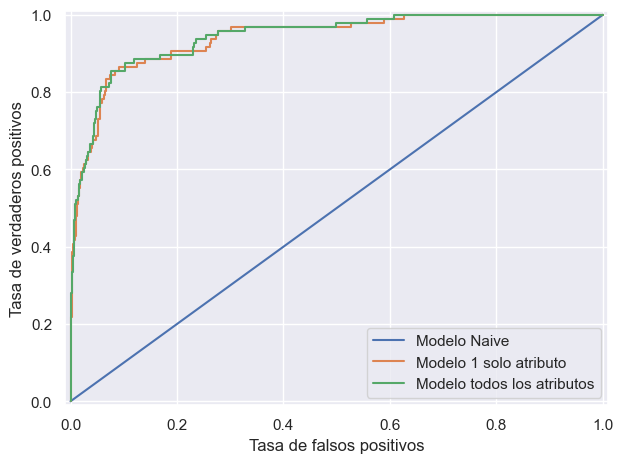

In [41]:
plt.plot(fpr_naive, tpr_naive, label="Modelo Naive")
plt.plot(fpr_balance, tpr_balance, label="Modelo 1 solo atributo")
plt.plot(fpr_total, tpr_total, label="Modelo todos los atributos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.tight_layout();

In [42]:
fpr_naive, tpr_naive, _ = roc_curve(y_test, prob_naive)
fpr_balance, tpr_balance, thresholds = roc_curve(y_test, prob_balance)
fpr_total, tpr_total, _ = roc_curve(y_test_total, prob_total)

In [43]:
print("AUC")
print(f"Modelo Naive AUC: {auc(fpr_naive, tpr_naive)}")
print(f"Modelo 1 solo atributo AUC: {auc(fpr_balance, tpr_balance)}")
print(f"Modelo todos los atributos AUC: {auc(fpr_total, tpr_total)}")

AUC
Modelo Naive AUC: 0.5
Modelo 1 solo atributo AUC: 0.940702128397116
Modelo todos los atributos AUC: 0.943609608985025


### Gráfico de la frontera de decisión

Si tenemos un modelo con dos atributos, podemos graficar la frontera de decisión

In [44]:
X = default_df.loc[:, ["balance", "income"]].values
y = default_df.loc[:, "default"].values
X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Normalizamos
sc_X = StandardScaler()
X_train_two = sc_X.fit_transform(X_train_two)  

# Entrenamos el modelo por máxima verosimilitud
classifier_two = LogisticRegression(random_state = 0)
classifier_two.fit(X_train_two, y_train_two)

LogisticRegression(random_state=0)

In [45]:
# Crear la malla de puntos para el gráfico
X_set, y_set = X_test_two, y_test_two
X1, X2 = np.meshgrid(
    np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=1),
    np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=1)
)

X_cont = sc_X.transform(np.array([X1.ravel(), X2.ravel()]).T)

/var/folders/50/q05bl7gj7jxb0qq6rb67fp4m0000gn/T/ipykernel_55912/54003814.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


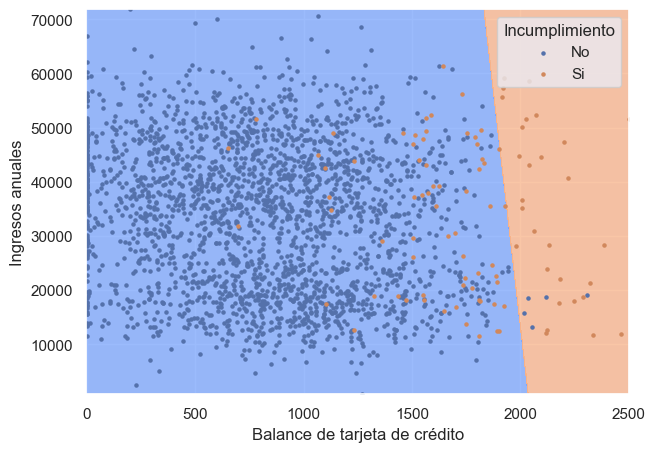

In [46]:
from matplotlib.colors import ListedColormap

# Crear el gráfico de contorno
plt.figure(figsize=(7, 5))
plt.contourf(
    X1, X2, classifier_two.predict(X_cont).reshape(X1.shape),
    alpha=0.75, cmap=ListedColormap(('#7aa5fb', '#f8b389'))
)
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Graficar los puntos de entrenamiento
lab = ["No", "Si"]
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(
        X_set[y_set == j, 0], X_set[y_set == j, 1],
        c=ListedColormap(('#5471ab', '#d1885c'))(i), label=lab[i],
        s=5
    )

plt.xlabel('Balance de tarjeta de crédito') 
plt.ylabel('Ingresos anuales') 
plt.legend(title="Incumplimiento")

plt.show()

## Clasificador KNN

Vamos a usar el clasificador KNN de [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). Para este ejemplo, vamos a usar el mismo dataset de la regresión logistica.

In [47]:
X = default_df.loc[:, ["balance", "income", "student"]].values
y = default_df.loc[:, "default"].values
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y, test_size = 0.25, random_state = 0)

sc_X = StandardScaler()
X_train_total = sc_X.fit_transform(X_train_total)
X_test_total = sc_X.transform(X_test_total)

In [48]:
# Entrenamos
from sklearn.neighbors import KNeighborsClassifier

classifier_knn_total = KNeighborsClassifier(n_neighbors=23, metric="minkowski", p=2)
classifier_knn_total.fit(X_train_total, y_train_total)

KNeighborsClassifier(n_neighbors=23)

In [49]:
#Evaluamos
y_pred_total  = classifier_knn_total.predict(X_test_total)

cm_knn_total = confusion_matrix(y_test_total, y_pred_total)

In [50]:
print("Knn con todos los atributos")
print(f"Precision: {precision_score(y_test_total, y_pred_total, zero_division=0)}")
print(f"Especificidad: {recall_score(y_test_total, y_pred_total, zero_division=0)}")
print(f"F1-score: {f1_score(y_test_total, y_pred_total, zero_division=0)}")

fpr_knn, tpr_knn, _ = roc_curve(y_test_total, y_pred_total)
print(f"Modelo Naive AUC: {auc(fpr_knn, tpr_knn)}")

Knn con todos los atributos
Precision: 0.8620689655172413
Especificidad: 0.2604166666666667
F1-score: 0.39999999999999997
Modelo Naive AUC: 0.6293763865779257


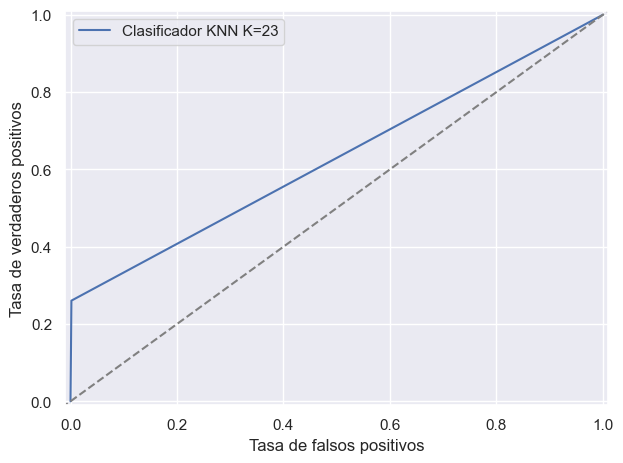

In [51]:
plt.plot(fpr_knn, tpr_knn, label="Clasificador KNN K=23")
plt.plot([-10, 10], [-10, 10], color="gray", linestyle="--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.tight_layout();

Veamos la frontera de decisión

In [52]:
X = default_df.loc[:, ["balance", "income"]].values
y = default_df.loc[:, "default"].values
X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(X, y, test_size = 0.25, random_state = 0)

sc_X = StandardScaler()
X_train_two = sc_X.fit_transform(X_train_two)

classifier_knn_two = KNeighborsClassifier(n_neighbors=23, metric="minkowski", p=2)
classifier_knn_two.fit(X_train_two, y_train_two)

KNeighborsClassifier(n_neighbors=23)

/var/folders/50/q05bl7gj7jxb0qq6rb67fp4m0000gn/T/ipykernel_55912/3749757271.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


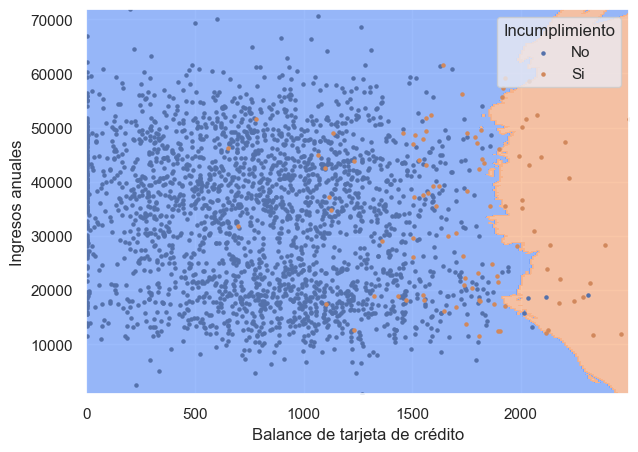

In [53]:
# Crear la malla de puntos para el gráfico
X_set, y_set = X_test_two, y_test_two
X1, X2 = np.meshgrid(
    np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=10),
    np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=10)
)

X_cont = sc_X.transform(np.array([X1.ravel(), X2.ravel()]).T)

# Crear el gráfico de contorno
plt.figure(figsize=(7, 5))
plt.contourf(
    X1, X2, classifier_knn_two.predict(X_cont).reshape(X1.shape),
    alpha=0.75, cmap=ListedColormap(('#7aa5fb', '#f8b389'))
)
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Graficar los puntos de entrenamiento
lab = ["No", "Si"]
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(
        X_set[y_set == j, 0], X_set[y_set == j, 1],
        c=ListedColormap(('#5471ab', '#d1885c'))(i), label=lab[i],
        s=5
    )

plt.xlabel('Balance de tarjeta de crédito') 
plt.ylabel('Ingresos anuales') 
plt.legend(title="Incumplimiento")

plt.show()